# Figure 6: Climatology

The posterior mean estimate of the average number of annual hail days over the region with a 95% credible interval (CI), in comparison with three threshold-based estimates of the same quantity. Again the coastlines and state border are shown in red with three regional centres referenced in other regional climatologies marked in white.

## Package imports

In [1]:
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

suppressPackageStartupMessages({
  library(tidyverse)
  library(posterior, lib.loc = additional_package_lib)
  library(patchwork)
  library(janitor, lib.loc = additional_package_lib)
  library(ozmaps, lib.loc = additional_package_lib)  
  library(sf)
  library(scico)
})

## Utility functions

In [2]:
inv_logit <- function(x){
  # The inverse logit or sigmoid function, used often in calculating probabilities
  #
  # Inputs:
  #  x  numeric, can be a vector
  #
  # Outputs:
  #  _  same shape as input, will be in (0, 1)

  1 / (1 + exp(-x))
}

yeo_johnson <- function(x, lambda) {
  # Yeo-Johnson transform of x using parameter lambda
  #
  # Inputs:
  #  x       numeric
  #          the numeric (vector) to be transformed
  #  lambda  numeric
  #          real parameter defining the transform
  # 
  # Outputs:
  #  _       numeric
  #          transformed vector same shape as x
    
  eps <- 1e-5
  if (x >= 0.0){
    if (abs(lambda) < eps){
      log1p(x)
    } else {
      (((x + 1.0) ^ lambda) - 1.0) / lambda
    }
  } else {
    if (abs(lambda - 2.0) < eps) {
      -log1p(-x)
    } else {
      -(((-x + 1.0) ^ (2.0 - lambda)) - 1.0) / (2.0 - lambda)
    }
  }
}

In [3]:
# utility quantile function 
function_quantiles_from_draws <- function(x_matrix, par_matrix, name){
  # (simplified) function which, given a matrix at which to evaluate the probability,
  # will employ the given simulation draws to calculate quantiles of said
  # probability at each evaluation point. 
  # 
  # Inputs:
  #  x_matrix      matrix (neval x npars)
  #                each row representats a point at which to evaluate
  #                the probability and calculate its statistics
  #  par_matrix    matrix (ndraws x npars)
  #                contains draws of the parameters from stan
  #  name          str
  #                used to name the columns of the resulting tibble
  #
  # Outputs:
  #  _             tibble (neval x 8)
  #                each row corresponds to a row in x_matrix with columns
  #                corresponding to statistics (e.g. <name>_2_5_percent, ...)
  
  # create mat_func: matrix with probability at each x location (row) for 
  # the number of simulations (col)
  
  # assumes 3rd element of beta used to transform second element of x
  # written for mesh but works equally well for population density
  
  # pre-allocate matrix for the raw multiplication results
  raw_mult <- matrix(0, nrow = nrow(x_matrix), ncol = nrow(par_matrix))
  # fill matrix by column
  for (j in 1:ncol(raw_mult)) {
    # transform mesh (second column) using jth parameter in third column
    mesh_trans <- map_dbl(x_matrix[, 2], \(x) yeo_johnson(x, par_matrix[j, 3]))
    # create new matrix with this second column 
    if (ncol(x_matrix) == 2) {
      mesh_trans_matrix <- cbind(x_matrix[, 1], mesh_trans)
    } else {
      mesh_trans_matrix <- cbind(x_matrix[, 1], mesh_trans, x_matrix[, 3:ncol(x_matrix)])
    }
    # doing the matrix multiplication to get that one column
    # should need transpose but R does it itself for a vector
    raw_mult[, j] <- mesh_trans_matrix %*% par_matrix[j, -3] 
  }
  # inverse logit transform of the matrix to get probabilities 
  mat_func <- inv_logit(raw_mult)
    
  # using apply to take quantiles over matrix
  apply(mat_func, MARGIN = 1, FUN = quantile, 
    # note changed probs
    probs = c(0.005, 0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975, 0.995)) %>%
    t() %>%
    # adding row means 
    cbind(mean = rowMeans(mat_func)) %>% 
    # converting to tibble
    as_tibble(.name_repair = "unique") %>% 
    # rename: <NAME>_2_5_percent, <NAME>_5_percent, etc.
    rename_with(~ paste(name, gsub("x", "", make_clean_names(.x)), sep = "_"))
}

## Reading in data

In [4]:
# model data: report is factor
model_data <- read_csv(paste0("/g/data/w42/ig1052/bayesian_paper_data/modelling_data/",
                              "filtered_allpredictors_noedges_popdens_ssa_variable_",
                              "diameter_comment_radar_66_variable_mesh_t_x_y_binned_t_",
                              "2010-01-01_2016-04-24_6_x_151.75_153.50_0.25_y_-29.00_",
                              "-26.50_0.25.csv"),
                      col_types = "nnTnnnnnnncnffffff")

In [5]:
# best model and its location
model_to_use <- "hail_trans_std_mesh_report_trans_std_dens_yjwide_gamma"
base_dir <- "/g/data/w42/ig1052/bayesian_paper_data/model_eval"

# reading in model parameters
model_params <- readRDS(paste(base_dir, model_to_use, "results", 
                              paste0(model_to_use, "_model_params_full.rds"), sep = "/"))

## Relevant calculations

In [6]:
# the observed MESH values at which we need the probability of hail
x_matrix <- cbind(1, model_data$mesh)

# getting the relevant hail parameters
suppressWarnings({
  par_matrix <- model_params[, , c("beta_hail[1]", "beta_hail[2]", "beta_hail[3]")] %>% 
    as_draws_df %>%
    select(starts_with("beta")) %>% # selecting columns creates warning
    as.matrix
})

# calculating the hail function qunatiles
full_uncertainty <- function_quantiles_from_draws(x_matrix = x_matrix, 
                                                  par_matrix = par_matrix, 
                                                  name = "hail")

In [7]:
# extracting number of hail days

# first joining the model data and the quantiles
hail_days_to_plot <- bind_cols(model_data, full_uncertainty) %>%
  # adding column for the radar climatology with multiple threhsolds
  mutate(hail_30 = as.integer(mesh > 30),
         hail_40 = as.integer(mesh > 40),
         hail_50 = as.integer(mesh > 50)) %>%
  # selecting only relevant columns
  select(c(hail_2_5_percent, hail_mean, hail_97_5_percent, ends_with("bins"), ends_with("0"), -hail_size)) %>%
  # grouping by date not time bins
  group_by(lubridate::date(time_bins), x_bins, y_bins) %>%
  # processing to hail days
  # P(at least one hail event on day) = 1 - prod_{cells} P(no hail in that cell)
  summarise(across(starts_with("hail"), function(x) 1 - prod(1 - x)), .groups = "drop") %>%
  # grouping spatially
  group_by(x_bins, y_bins) %>%
  # summing over data and annualising
  summarise(across(starts_with("hail"), function(x) sum(x) / 6.5), .groups = "drop")

## Plotting

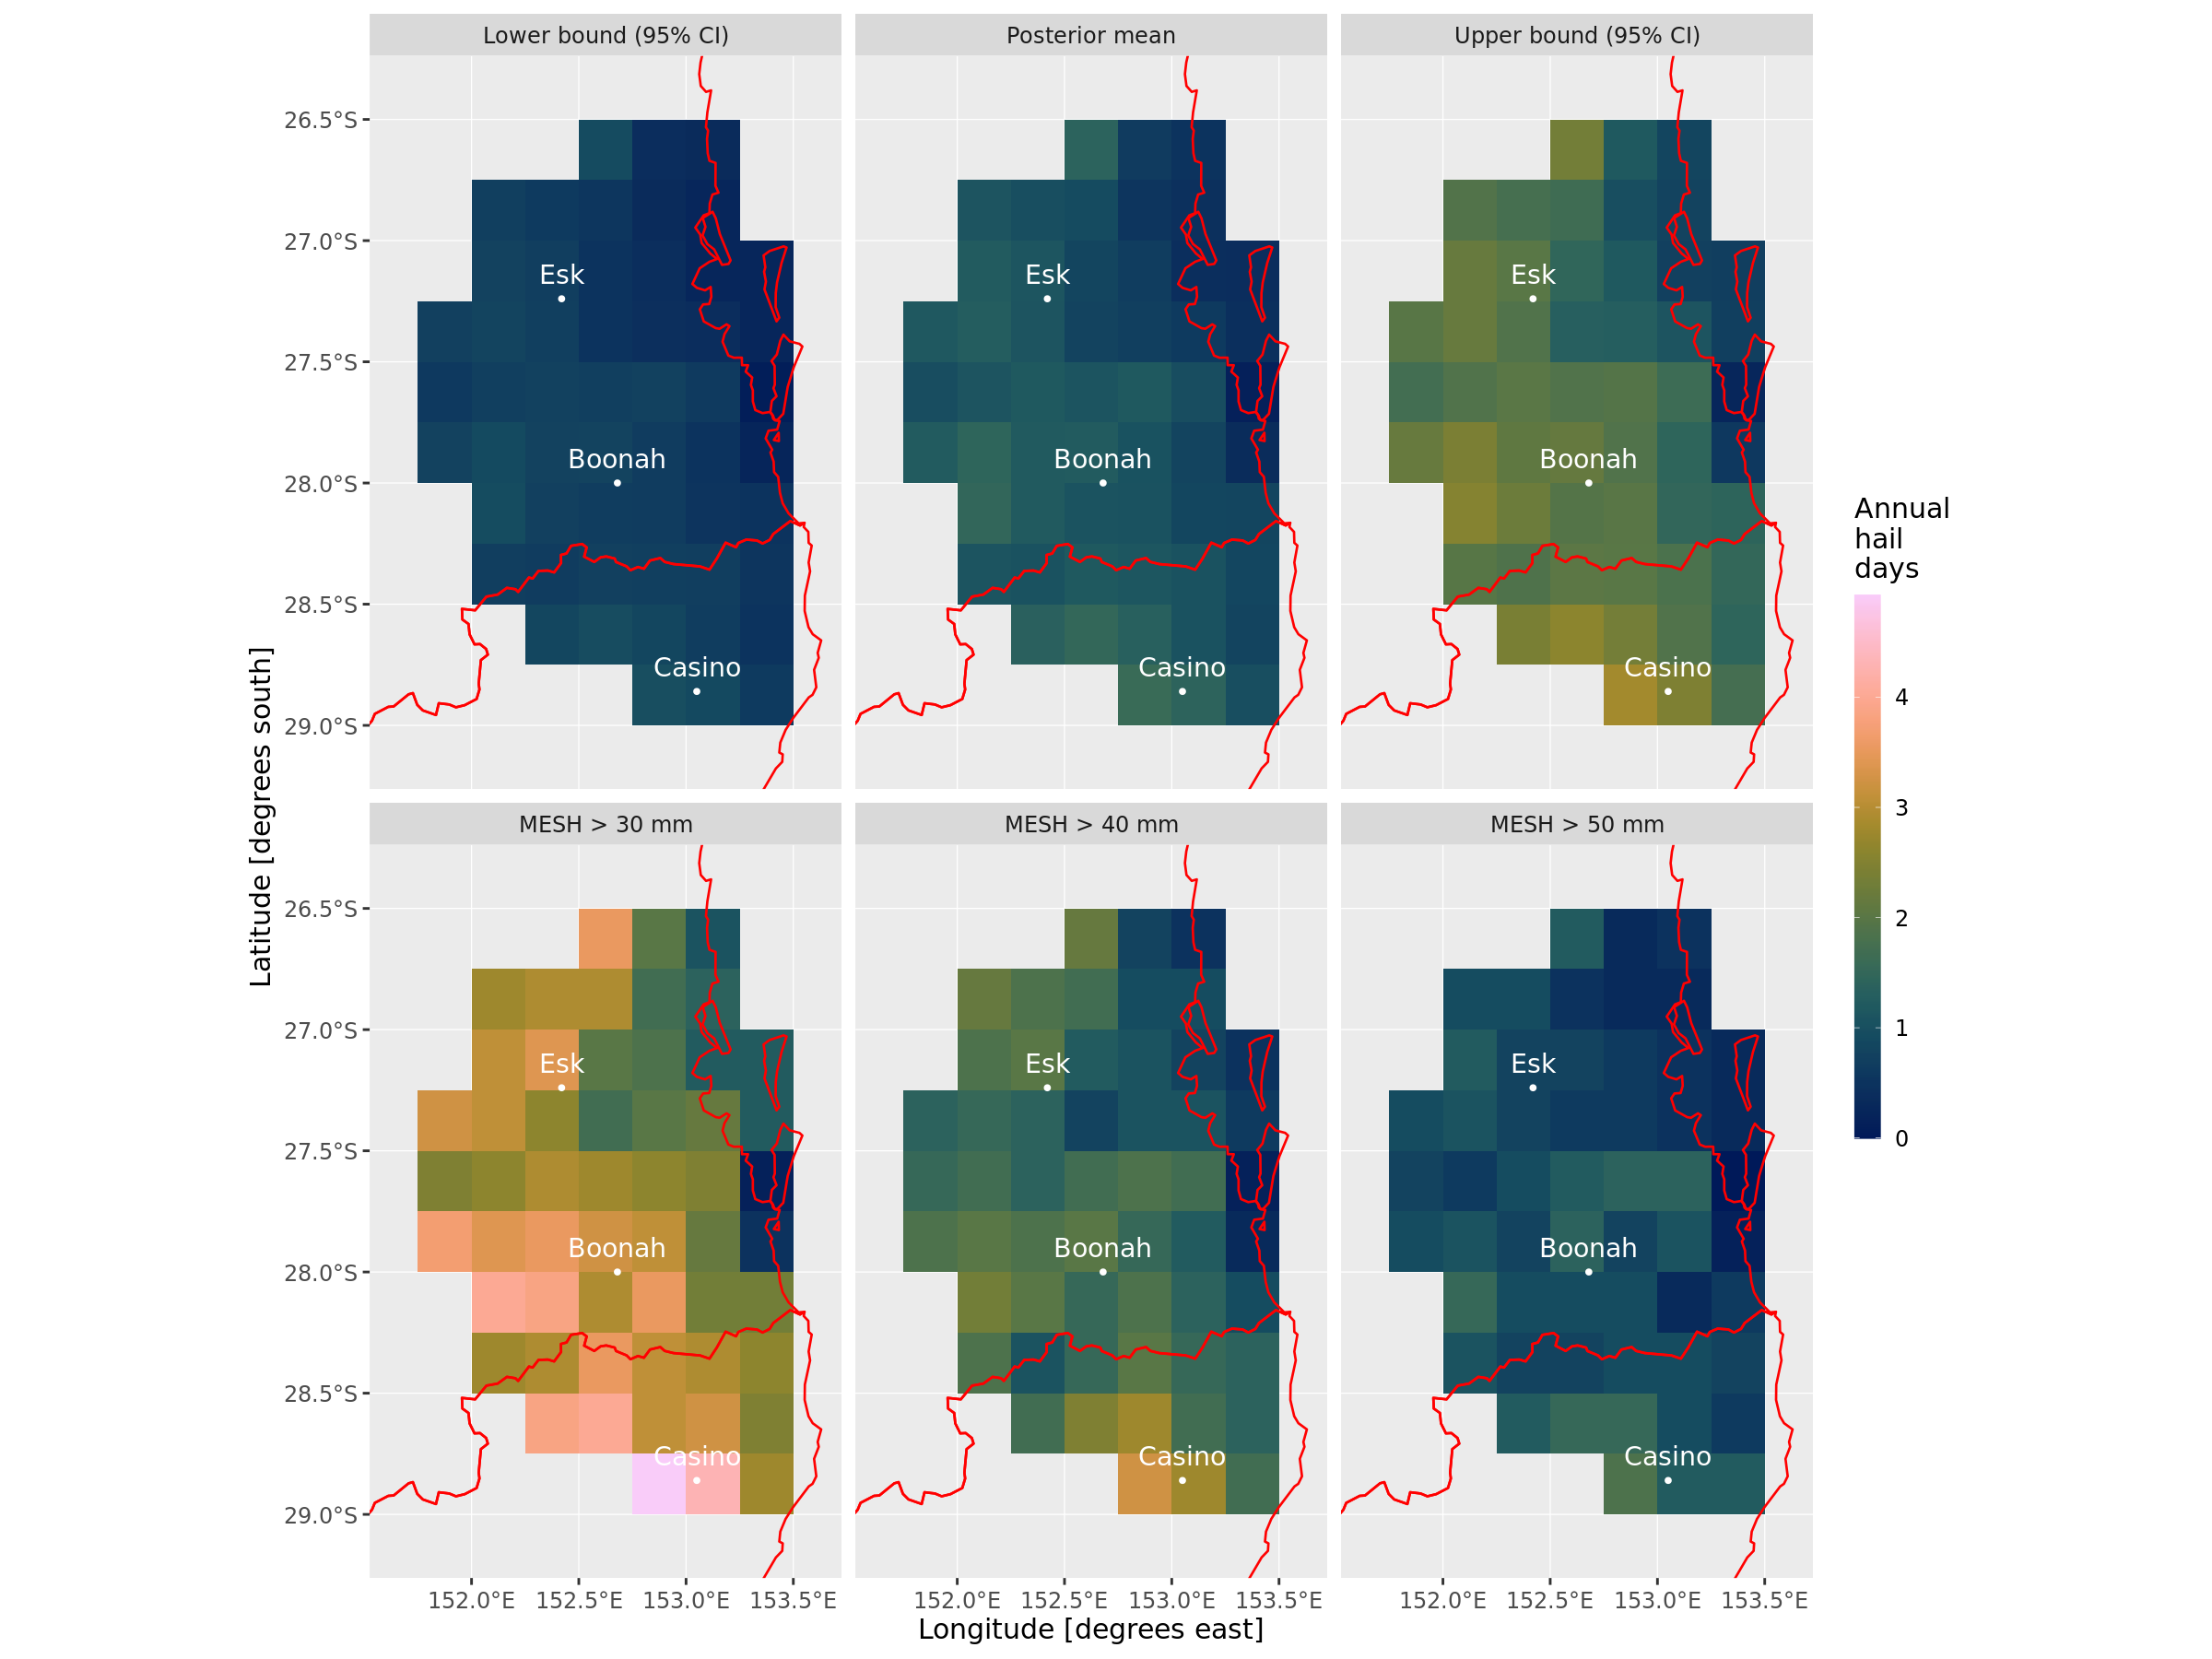

In [8]:
# viewing size
options(repr.plot.width = 20, repr.plot.height = 15)

# annotation parameters
annotate_colour <- "white"
annotate_size <- 6

hail_days_to_plot %>%
  # renaming columns for display
  rename(`MESH > 30 mm` = hail_30,
         `MESH > 40 mm` = hail_40,
         `MESH > 50 mm` = hail_50,
         `Lower bound (95% CI)` = hail_2_5_percent,
         `Upper bound (95% CI)` = hail_97_5_percent,
         `Posterior mean` = hail_mean) %>%
  # pivoting for plottting                
  pivot_longer(-ends_with("bins")) %>%
  # remaking the factor orders the plot
  mutate(across(name, ~factor(., 
                              levels=c("Lower bound (95% CI)", "Posterior mean", 
                                       "Upper bound (95% CI)", "MESH > 30 mm", 
                                       "MESH > 40 mm", "MESH > 50 mm")
                             )
               )
        ) %>%
  # plotting
  ggplot() + 
  geom_tile(aes(x = x_bins, y = y_bins, fill = value)) +
  # colour palette
  scale_fill_scico(palette = "batlow") +
  # adding in state
  geom_sf(data = ozmap_states, color = "red", fill = NA, linewidth = 0.75) + 
  # shaping plot for map
  coord_sf() + 
  # limits given by data
  xlim(c(min(model_data$x_bins) - 0.25, max(model_data$x_bins) + 0.25)) + 
  ylim(c(min(model_data$y_bins) - 0.25, max(model_data$y_bins) + 0.25)) +
  # labelling
  xlab("Longitude [degrees east]") +
  ylab("Latitude [degrees south]") +
  labs(fill = "Annual\nhail\ndays") +
  # size
  theme_gray(base_size = 18) + 
  # spilitting by climatology type
  facet_wrap(~ name) +
  # stretching legent
  theme(legend.key.height = unit(2.5, "cm")) +
  # annotating with key points, data made on the fly
  geom_point(aes(x = x, y = y), data = tribble(~y,     ~x, 
                                               -27.24, 152.42,  
                                               -28.00, 152.68, 
                                               -28.86, 153.05), 
             color = annotate_colour) +
  # labelling cities
  annotate("text", x = 152.42, y = -27.24 + 0.1, label = "Esk", 
           color = annotate_colour, size = annotate_size) +
  annotate("text", x = 152.68, y = -28.00 + 0.1, label = "Boonah", 
           color = annotate_colour, size = annotate_size) +
  annotate("text", x = 153.05, y = -28.86 + 0.1, label = "Casino", 
           color = annotate_colour, size = annotate_size)